# SuperStore Sales Forecasting 

<p aling='justify'> This analysis provide sales forecasting basing on super store dataset.</p>

Table of contents:
1. Notebook setup and modules import 
2. Data preprocessing
3. Data analysis and visualisation 
4. Stationarity analysis 
5. Trend & seasonality analysis
6. Differencing
6. ARIMA & SARIMAX
7. Best model selecetion and forecasts
8. Conclusions

### 1. Notebook setup and modules import

In [42]:
%pip install -r Config/requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sqlalachemy (from versions: none)
ERROR: No matching distribution found for sqlalachemy


In [43]:
%load_ext sql 

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [44]:
%sql mssql+pyodbc://PLLUKOR1@local

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker

In [46]:
%sql use SuperStore;

 * mssql+pyodbc://PLLUKOR1@local
Done.


[]

In [47]:
import warnings

warnings.filterwarnings("ignore")

### 2. Data preprocessing

Data gathered from database requires column mapping: 
* *decimal(10,2) -> np.float64*
* *datetime -> pd.datetime* 

Additionaly time series analysis requires datetime index.

In [48]:
query = '''
SELECT CAST(OderDate as DATE) as Date
        ,Sales
FROM Orders
ORDER BY Date
'''
results = %sql $query
results = pd.DataFrame(results)
results['Sales'] = results['Sales'].astype(np.float64)
results['Date'] = pd.to_datetime(results['Date'], format= "%Y-%m-%d")
results.set_index('Date', inplace=True)
data = results

 * mssql+pyodbc://PLLUKOR1@local
Done.


### 3. Data Analysis and Visualisation 

<p aling='justify'>To perform data preprocessing and time series forecasting properly, sufficient amount of sample is required. During the differencing process some cases are lost, so it is important to have as many data samples as possible with high flexibility according to generealization. SuperSotre dataset includes sales data for range of 4 years. Chosing proper basis is a key factor for time series forecasting and it is first step to do before kicking-off forecasting task. <p> 

In [49]:
xlines = np.array(['2014-02-01','2014-08-01', '2015-02-01', '2015-08-01','2016-02-01', '2016-08-01','2017-02-01', '2017-08-01'], dtype='datetime64[D]')

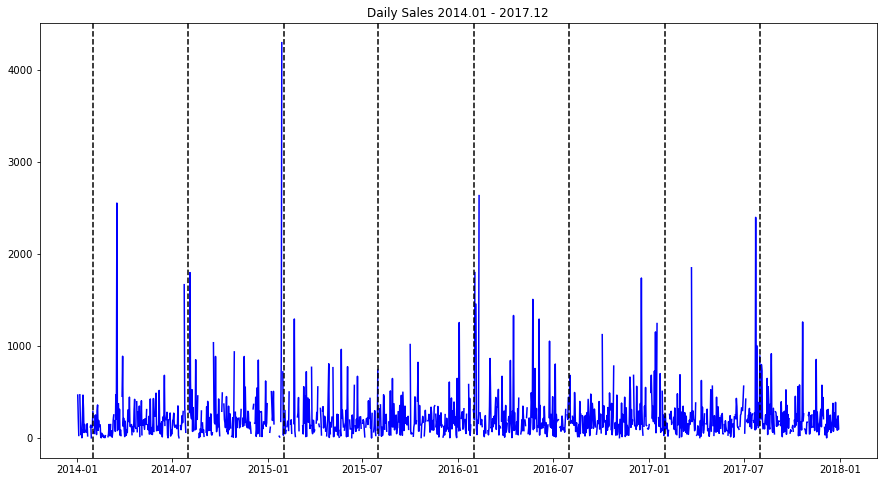

In [50]:
dailyData = data.resample('1D')
dailyData = dailyData.agg({'Sales':'mean'})

fig, axes = plt.subplots(1, 1,figsize=(15, 8))

axes.plot(dailyData, color='blue')
axes.set_title('Daily Sales 2014.01 - 2017.12')
for line in xlines:
    plt.axvline(x=line, color='black', linestyle='--')
plt.show()

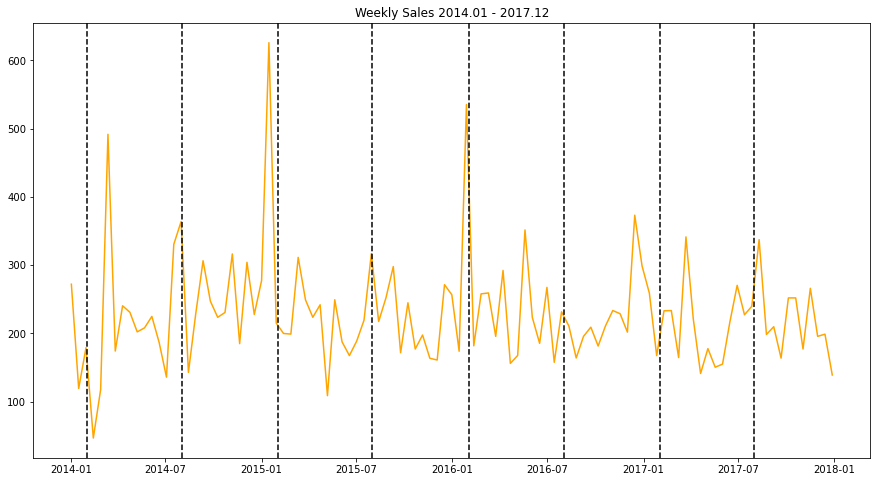

In [51]:
weeklyData = data.resample('14D')
weeklyData = weeklyData.agg({'Sales':'mean'})

fig, axes = plt.subplots(1, 1,figsize=(15, 8))

axes.plot(weeklyData, color='orange')
axes.set_title('Weekly Sales 2014.01 - 2017.12')
for line in xlines:
    plt.axvline(x=line, color='black', linestyle='--')
plt.show()

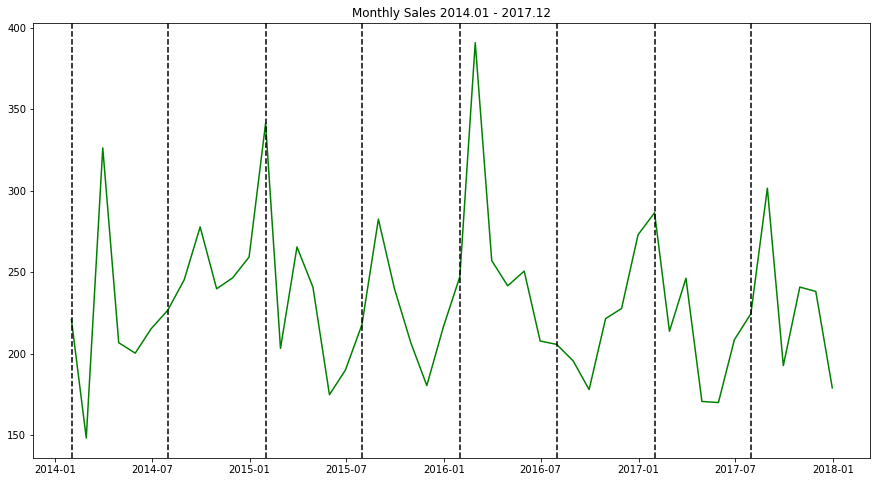

In [52]:
monthlyData = data.resample('1M')
monthlyData = monthlyData.agg({'Sales':'mean'})

fig, axes = plt.subplots(1, 1,figsize=(15, 8))

axes.plot(monthlyData, color='green')
axes.set_title('Monthly Sales 2014.01 - 2017.12')
for line in xlines:
    plt.axvline(x=line, color='black', linestyle='--')
plt.show()

##### Dates range
<p align='justify'> ARIMA forecasting models are less accurate for time highly grataded data for example: Stock data updated on hourly base. Montly basis of aggregation could be best for this forecasting task but data set provides only 48 samples for montly sales. 2 week basis for aggregation should provide enough samples to make proper predictions for historical and future sales. </p>

##### Proper aggregation 
<p align='justify'>To generalize data its necessary to pick correct aggregation which. Quantilies and outliers will not be good estimators for periodical sales data. The best choose is biweekly median or mean. In this case mean is the best pick for forecasting task because it brings more valuable information about sales. </p>

### 4. Stationary analysis

To test time series stationarity adfuler test has to be involved.

*H<sub>0</sub>: Time series is not stationary, there is unit root*
<br>
*H<sub>1</sub>: Time series is  stationary, there is no unit root*

In [53]:
from statsmodels.tsa.stattools import adfuller

In [54]:
def stationaryTest(sales):
    test = adfuller(sales)

    statistics = ['ADF', 'P-value', 'Lags', 'Samples']
    for value, statistic in zip(test, statistics):
        print(f'{statistic} : {value}')

    if test[1] <= 0.05:
        print(f'P-value = {test[1]:.2f}\nStrong evidence aganist null hypothesis. Null hypothesis rejected - data is stationary.')
    else:
        print(f'P-value = {test[1]:.2f}\nWeak evidence aganist null hypothesis. Null hypothesis accepted - data is not stationary.')


In [55]:
stationaryTest(weeklyData)

ADF : -10.672814441136984
P-value : 4.125412767224736e-19
Lags : 0
Samples : 104
P-value = 0.00
Strong evidence aganist null hypothesis. Null hypothesis rejected - data is stationary.


In [56]:
stationaryData = weeklyData

### 5. Trend and seasonality analysis

Another step to be done before permorming forecasting task is autocorrelation and seasonality analysis.

In [57]:
from pandas.plotting import autocorrelation_plot

Autocorrelation plot

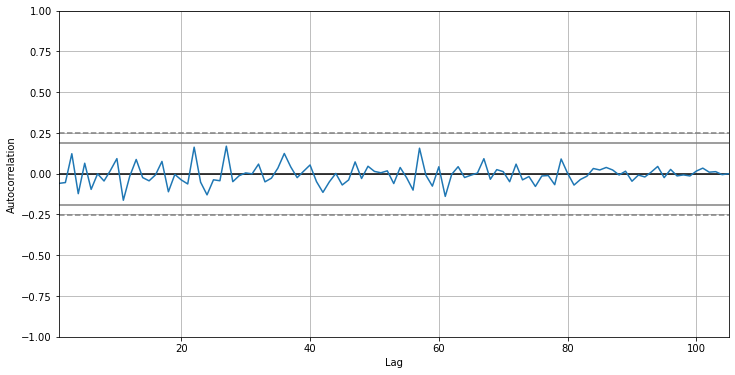

In [58]:
fig, axes = plt.subplots(1, 1,figsize=(12, 6))

autocorrelation_plot(stationaryData['Sales'])
plt.show()

In [59]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

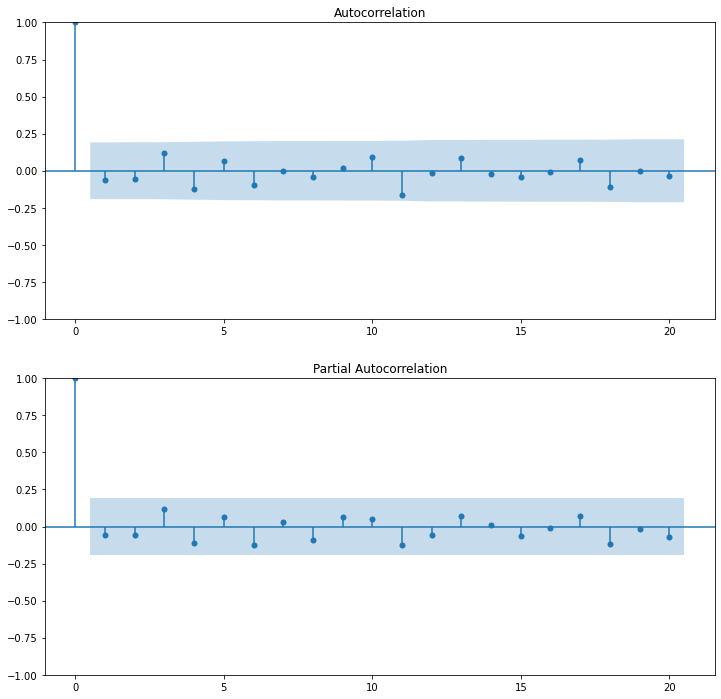

In [60]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

plot_acf(stationaryData, lags=20, ax=axes[0])
plot_pacf(stationaryData, lags=20, ax=axes[1], method='ywm')
plt.show()

In [61]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [62]:
decompositionAnalysis = seasonal_decompose(stationaryData)

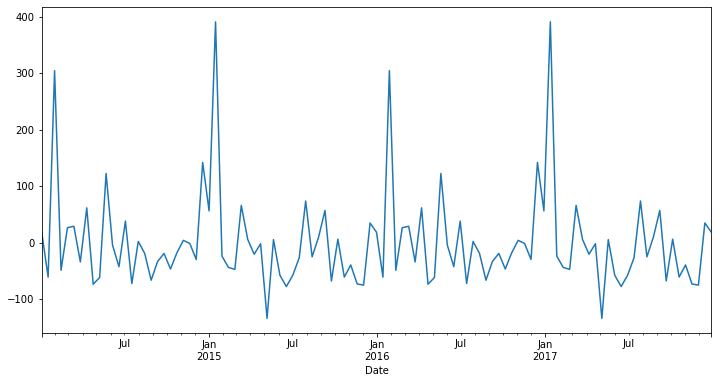

In [63]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
decompositionAnalysis.seasonal.plot()
plt.show()

### 6. Differencing & visualization

Dataset has incosistent seasonality over time, so it is not possible to apply diffentation basing on wider time window. 2-month basis for seasonal differentation will be the best fit - every 2 month sales increase and decrease alternately.

In [64]:
stationaryData['Sales'] = stationaryData['Sales'] - stationaryData['Sales'].shift(1)

In [65]:
stationaryData['Sales'] = stationaryData['Sales'] - stationaryData['Sales'].shift(4)

In [66]:
stationaryData.dropna(inplace=True, axis=0)

In [67]:
print("Performing stationary test for differenced data")
stationaryTest(stationaryData['Sales'])

Performing stationary test for differenced data
ADF : -5.42852109048697
P-value : 2.9500008828280333e-06
Lags : 12
Samples : 87
P-value = 0.00
Strong evidence aganist null hypothesis. Null hypothesis rejected - data is stationary.


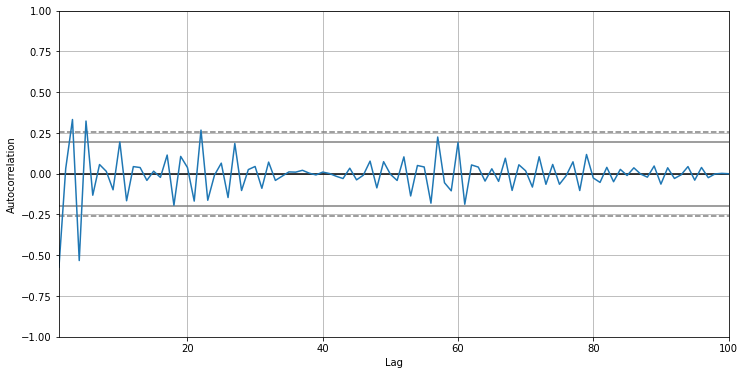

In [68]:
fig, axes = plt.subplots(1, 1,figsize=(12, 6))

autocorrelation_plot(stationaryData['Sales'])
plt.show()

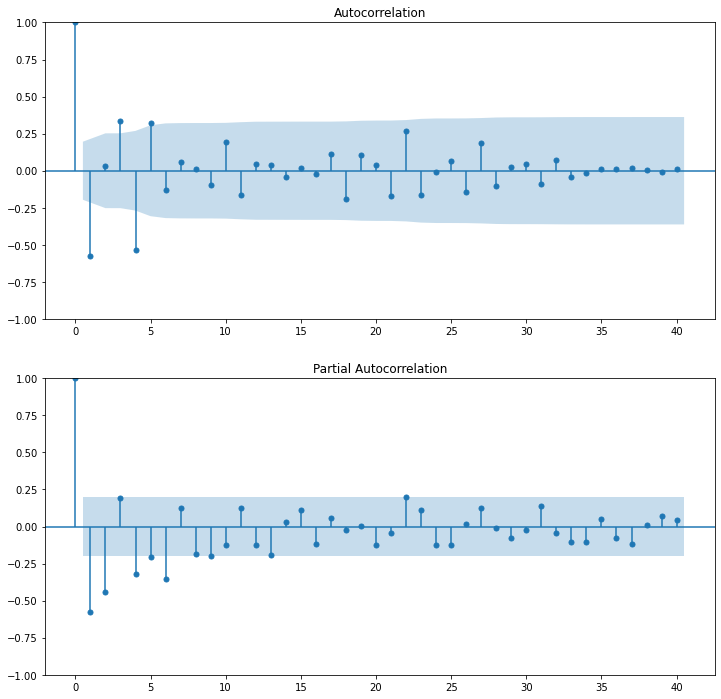

In [69]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

plot_acf(stationaryData, lags=40, ax=axes[0])
plot_pacf(stationaryData, lags=40, ax=axes[1], method='ywm')
plt.show()

Differencing caused significantly higher autocorrelation for *LAG <= 20* but this coefficient decreases rapidly. 

### 7. ARIMA & Seasonal Arima 

SuperSotre data proves some seasonal tendency. Comparison of autoregressive integrating moving average model and it's seasonal version will give the answer about estimations for the future sales.

ARIMA predictions

In [70]:
from statsmodels.tsa.arima.model import ARIMA

In [71]:
arima = ARIMA(stationaryData, order = (2, 2, 2)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  100
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -625.356
Date:                Sat, 09 Apr 2022   AIC                           1260.712
Time:                        15:10:01   BIC                           1273.636
Sample:                    03-13-2014   HQIC                          1265.939
                         - 12-28-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8746      0.079    -11.095      0.000      -1.029      -0.720
ar.L2         -0.4690      0.087     -5.396      0.000      -0.639      -0.299
ma.L1         -1.9960      0.147    -13.535      0.000      -2.285      -1.707
ma.L2          0.9999      0.152      6.557      0.000       0.701       1.299
sigma2      1.741e+04   1.72e-05   1.01e+09      0.000    1.74e+04    1.74e+04
===================================================================================
Ljung-Box (L1) (Q):                   3.65   Jarque-Bera (JB):                 1.17
Prob(Q):                              0.06   Prob(JB):                         0.56
Heteroskedasticity (H):               0.40   Skew:                             0.25
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.54e+24. Standard errors may be unstable.
"""

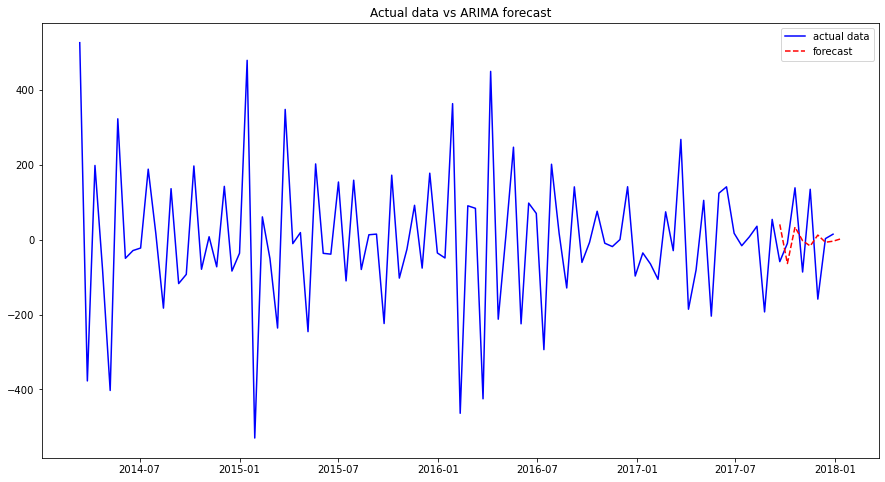

In [72]:
fig, axes = plt.subplots(1, 1,figsize=(15, 8))

labels = ['actual data', 'forecast']

axes.plot(stationaryData, color='blue', label=labels[0])
axes.plot(arima.predict(start=92, end=100, dynamic=True), color='red', linestyle='dashed', label=labels[1])
axes.set_title('Actual data vs ARIMA forecast')
plt.legend()
plt.show()

SARIMAX predictions

In [73]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [74]:
sarimax = SARIMAX(stationaryData, order=(2, 2, 2), seasonal_order=(2, 2, 1, 4)).fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Sales   No. Observations:                  100
Model:             SARIMAX(2, 2, 2)x(2, 2, [1], 4)   Log Likelihood                -597.627
Date:                             Sat, 09 Apr 2022   AIC                           1211.255
Time:                                     15:10:02   BIC                           1231.253
Sample:                                 03-13-2014   HQIC                          1219.319
                                      - 12-28-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7803      0.104     -7.516      0.000      -0.984      -0.577
ar.L2         -0.4782      0.121     -3.966      0.000      -0.715      -0.242
ma.L1         -1.9742      0.510     -3.874      0.000      -2.973      -0.976
ma.L2          0.9850      0.502      1.962      0.050       0.001       1.969
ar.S.L4       -1.0033      0.102     -9.808      0.000      -1.204      -0.803
ar.S.L8       -0.5149      0.100     -5.139      0.000      -0.711      -0.319
ma.S.L4       -0.9999      0.534     -1.872      0.061      -2.047       0.047
sigma2      2.154e+04   2.49e-05   8.66e+08      0.000    2.15e+04    2.15e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 1.05
Prob(Q):                              0.62   Prob(JB):                         0.59
Heteroskedasticity (H):               0.46   Skew:                            -0.09
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.1e+24. Standard errors may be unstable.
"""

<p align='justify'>Data preprocessing and explonatory data analysis has led to two step data differentation. (first difference and seasonal). This requeire additional configuraion of ARIMA parameters. </p>


Characteristics of preprocessed data:
* Date range after differentation *03-13-2014 - 12-28-2017*
* Mean aggregation on 2 week basis
* First difference
* Seasonal difference: *(4 * 2 weeks ~ 2 months)*
* Stationarity test: p-value = *2.9500008828280333e-06*
* Rolling average: not applied


Seasonal ARIMA configuration:

* *p (AR) - autoregressive model lags = 2*
* *d (I) - times data has been differenced = 2*
* *d (MA) - lags from moving average = 2*

*Seasonal Order = (2, 2 , 1, 4)*

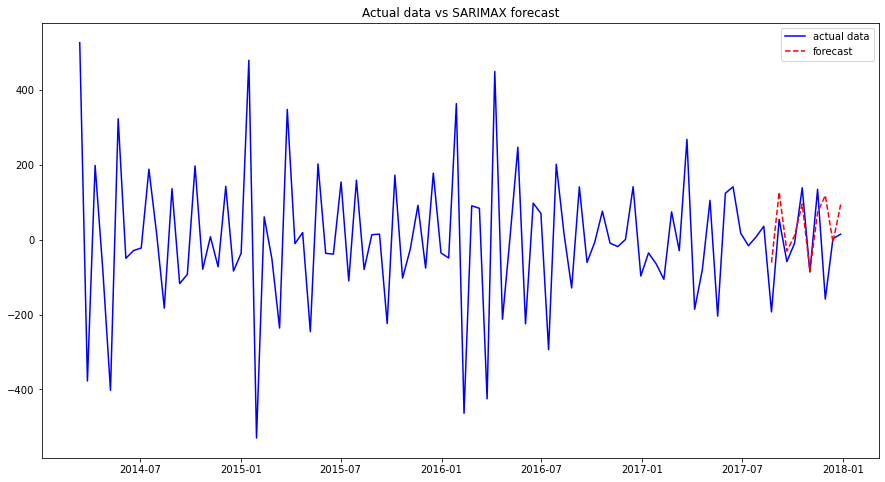

In [75]:
fig, axes = plt.subplots(1, 1,figsize=(15, 8))

labels = ['actual data', 'forecast']

axes.plot(stationaryData, color='blue', label=labels[0])
axes.plot(sarimax.predict(start=90, end=99, dynamic=True), color='red', linestyle='dashed', label=labels[1])
axes.set_title('Actual data vs SARIMAX forecast')
plt.legend()
plt.show()

Seasonal ARIMA provided much better fit than standard ARIMA model. Fit could be better if monthly sample was significantly bigger. Standard ARIMA was not able to make predictions for historical data properly. Because of data seasonality SARIMAX performed significantly better. Model's every coefficient is meaningful, *(p-value below or around 0.05)* which makes model statisticaly significant. 

Model Forecast

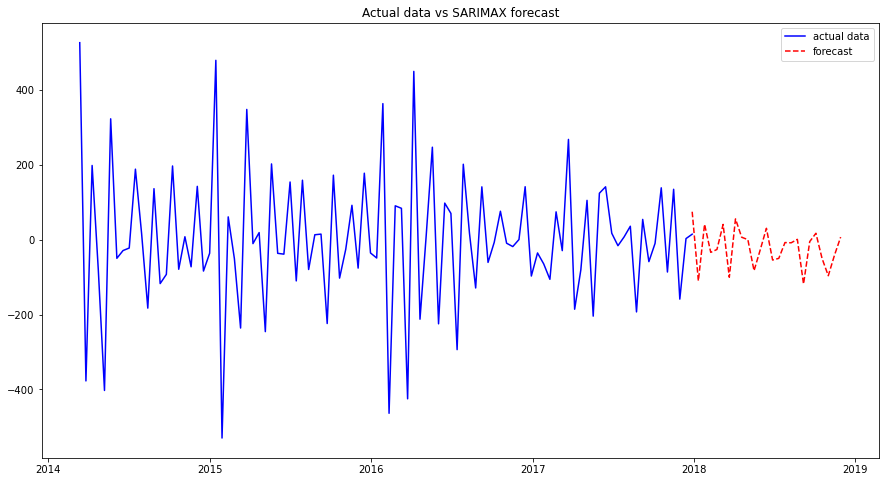

In [76]:
fig, axes = plt.subplots(1, 1,figsize=(15, 8))

labels = ['actual data', 'forecast']

axes.plot(stationaryData, color='blue', label=labels[0])
axes.plot(sarimax.predict(start=99, end=123, dynamic=True), color='red', linestyle='dashed', label=labels[1])
axes.set_title('Actual data vs SARIMAX forecast')
plt.legend()
plt.show()

### 9. Conclusions

<p align='justify'>Emplonatory data analysis answered questions about SuperStore data seasonality, trends and anomalies. Time series includes few "explosions" where sales increases and decreases rapidly in short period of time. This can be caused but many factor but most possible reasons are contracts for huge orders and  sales or promotional campaigns. Data has tendency to minimimze the variance over years. Sigificant seasonality is visible, but the most critical months are February and August. At every turn of the month occurs siginficant sales jump which decreaes after 2 or 3 days.  </p>

<p align='justify'>Forecasting analysis resulted reliable and statisticaly significant SARIMAX model which makes accurate predictions both to historical and future data. Time series differencing and decomposition only improved model performance. Observation and model perfomrance analysis has shown that standart ARIMA model is significantly less accurate than it's seasonal version. </p>